# Customer Churn Prediction

### Imports

In [1]:
# Tools
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lifelines import KaplanMeierFitter, CoxPHFitter
from xgboost import XGBClassifier

# Visualisation
import matplotlib.pyplot as plt
from lime import lime_tabular
import seaborn as sns

In [2]:
# Dataset Loading
dataset = pd.read_csv('../dataset/dataset.csv').iloc[:, 1:]

In [3]:
dataset.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [5]:
dataset.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


### Data Cleaning

In [6]:
new_columns = [re.sub(r'(?<!^)([A-Z])', r' \1', col).title() for col in dataset.columns]
new_columns[-8] = 'Streaming TV'
dataset.columns = new_columns

In [7]:
dataset.head()

,Gender,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [8]:
dataset = dataset[dataset['Total Charges'] != ' ']
dataset['Total Charges'] = dataset['Total Charges'].astype(float)

In [9]:
dataset['Multiple Lines'] = dataset['Multiple Lines'].replace(to_replace='No phone service', value='No service')
dataset.loc[:, ['Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies']] = dataset.loc[:, ['Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies']].replace(to_replace='No internet service', value='No service')

In [10]:
# Checking for Null Values
dataset.isna().sum()

Gender               0
Senior Citizen       0
Partner              0
Dependents           0
Tenure               0
Phone Service        0
Multiple Lines       0
Internet Service     0
Online Security      0
Online Backup        0
Device Protection    0
Tech Support         0
Streaming TV         0
Streaming Movies     0
Contract             0
Paperless Billing    0
Payment Method       0
Monthly Charges      0
Total Charges        0
Churn                0
dtype: int64

In [11]:
# Seperating Categorical and Numerical columns
categorical_columns = dataset.select_dtypes(include=['object']).columns.tolist()
numerical_columns = [col for col in dataset.columns if col not in categorical_columns]

### Data Visualisation

In [12]:
# Setting Seaborn Theme Style
sns.set_theme(style='darkgrid')

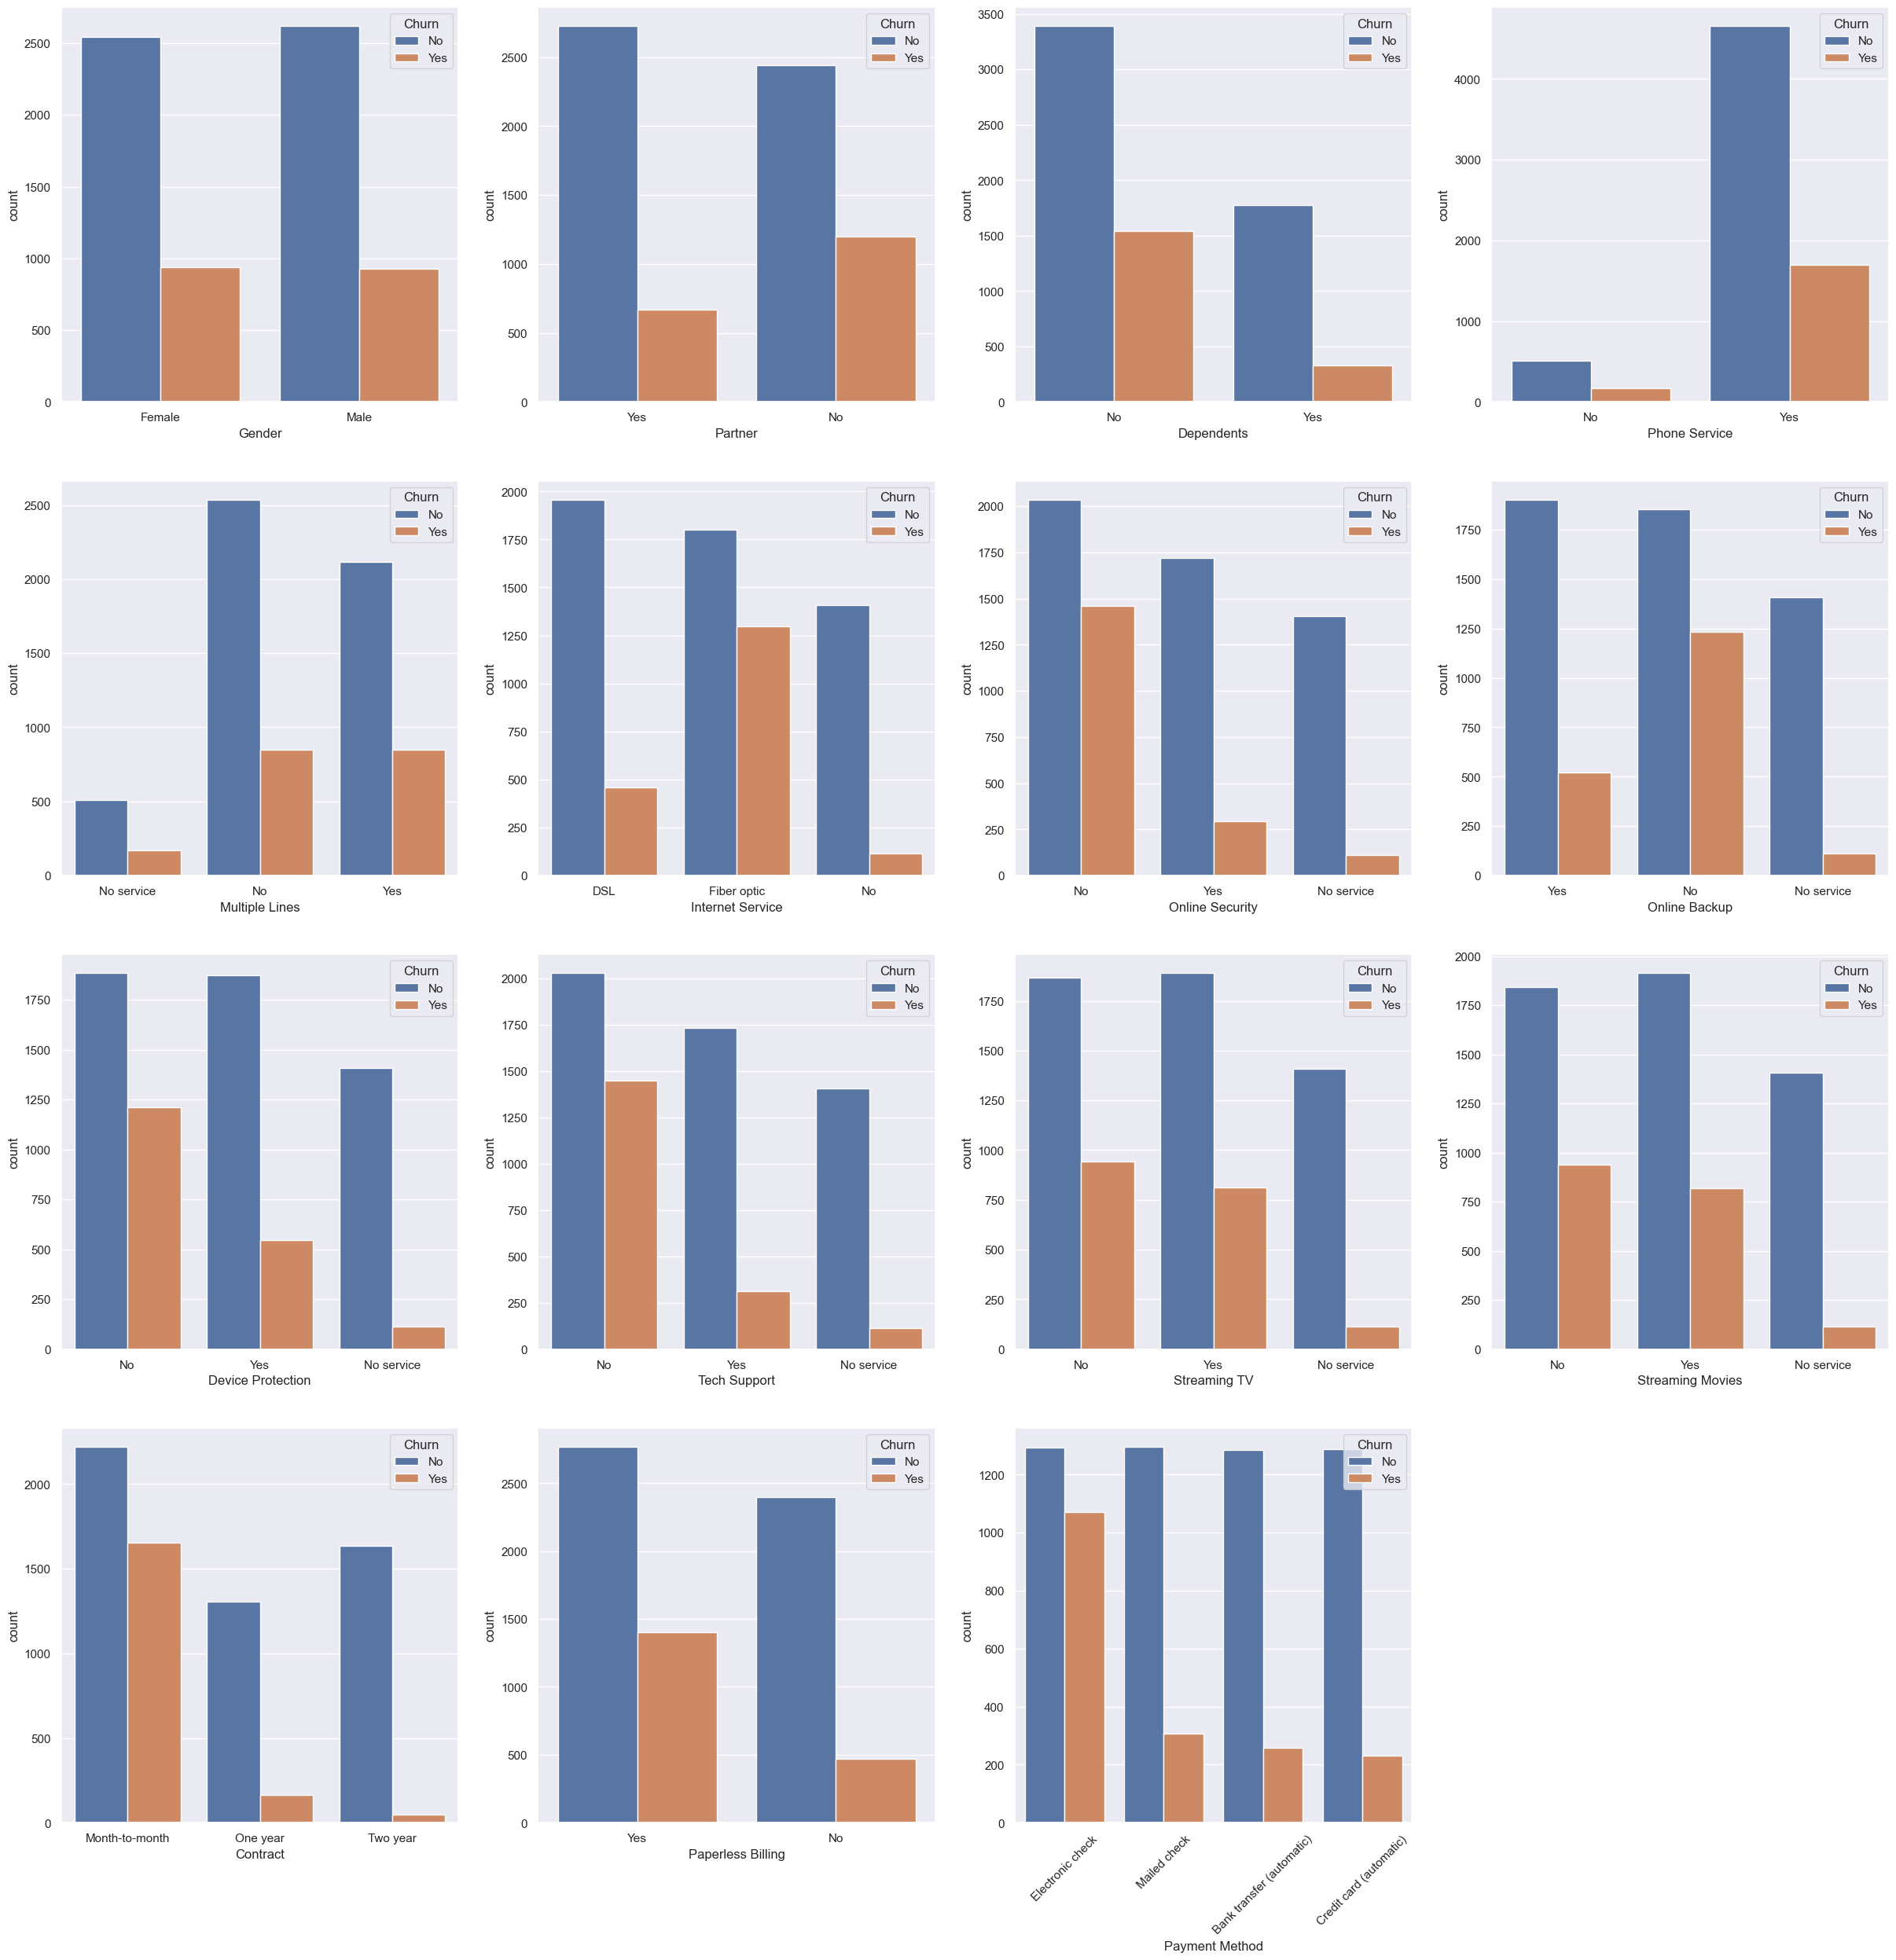

In [13]:
# Churn Distribution by Category
plt.figure(figsize=(30, 30))
for index, col in enumerate(categorical_columns):
    if col != 'Churn':
        plt.subplot(4, 4, index+1)
        sns.countplot(data=dataset, x=col, hue='Churn')
        if(len(dataset[col].unique()) > 3):
            plt.xticks(rotation=45)
plt.show()

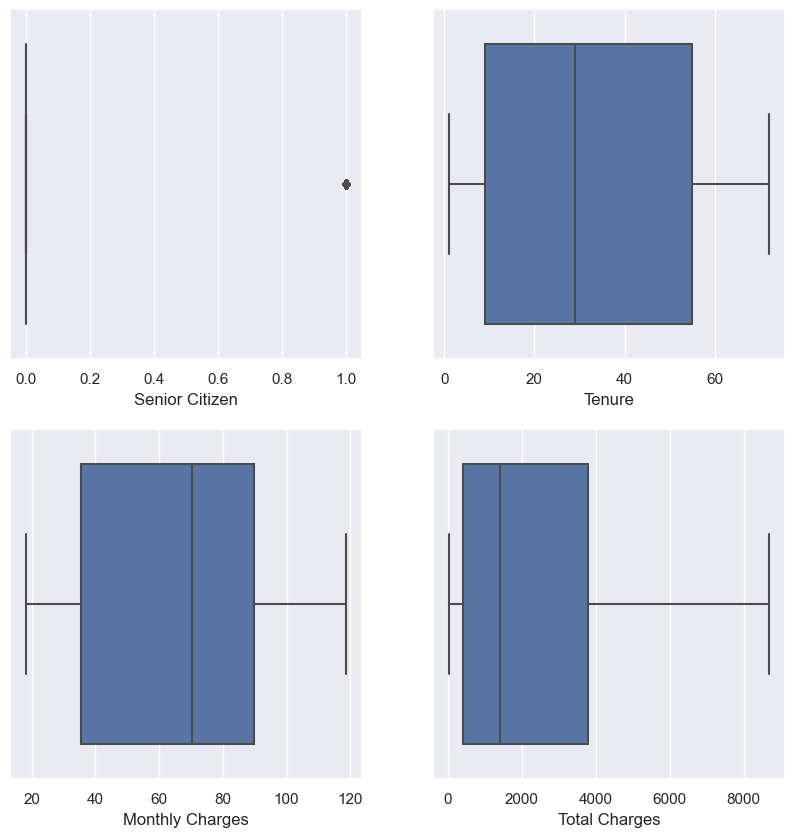

In [14]:
# Numerical Columns Distribution
plt.figure(figsize=(10, 10))
for index, col in enumerate(numerical_columns):
    plt.subplot(2, 2, index+1)
    sns.boxplot(data=dataset, x=col)
plt.show()

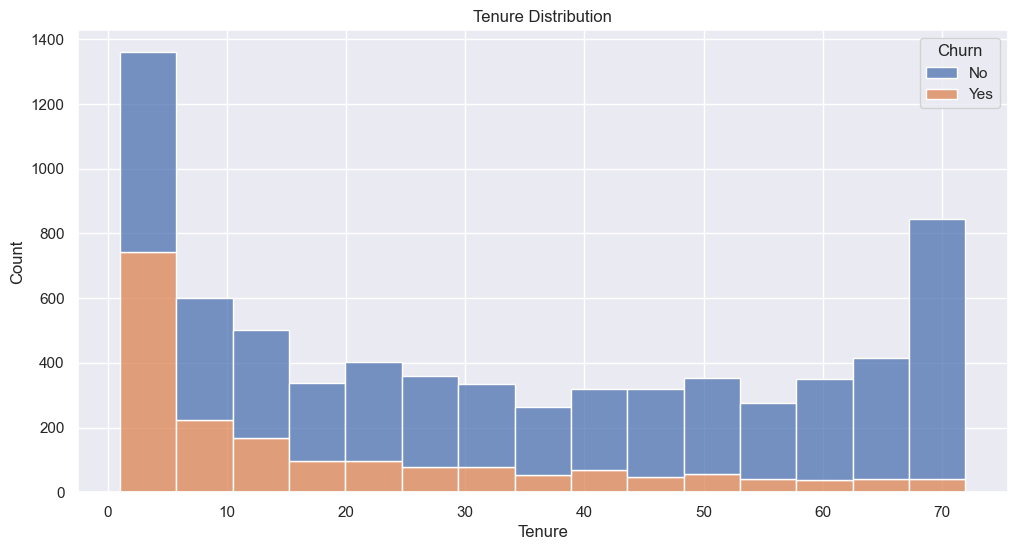

In [15]:
# Tenure Distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=dataset, x='Tenure', hue='Churn', multiple='stack')
plt.title('Tenure Distribution')
plt.show()

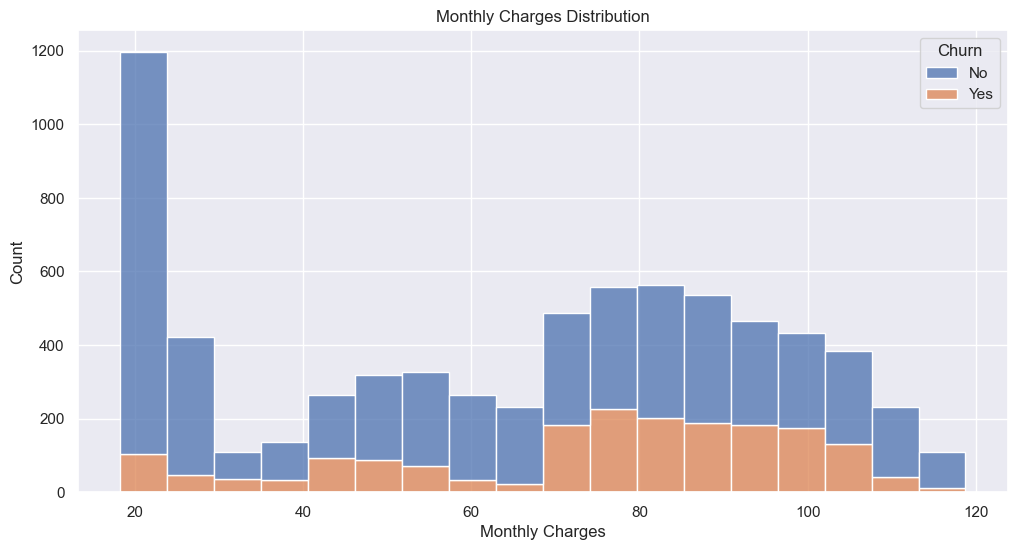

In [16]:
# Monthly Charges Distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=dataset, x='Monthly Charges', hue='Churn', multiple='stack')
plt.title('Monthly Charges Distribution')
plt.show()

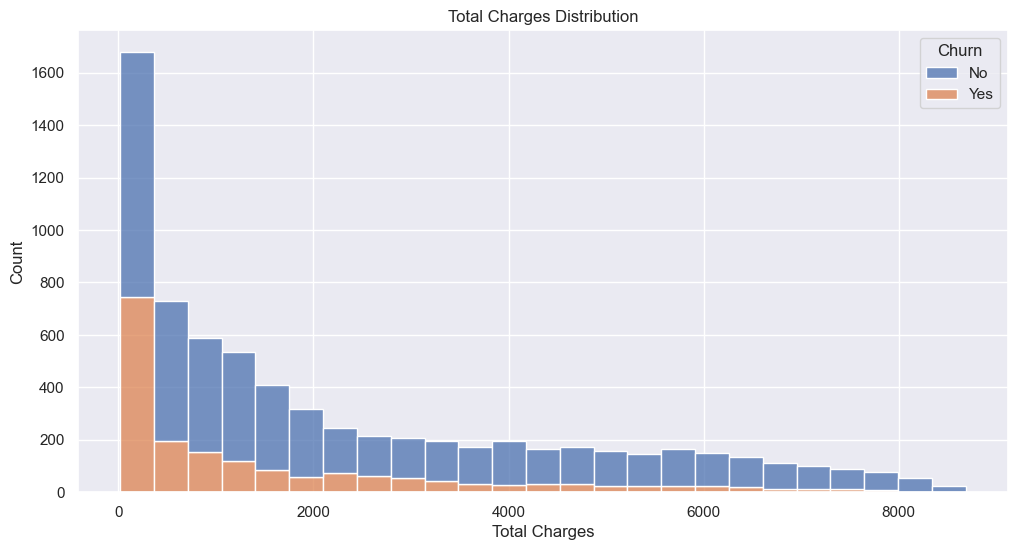

In [17]:
# Total Charges Distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=dataset, x='Total Charges', hue='Churn', multiple='stack')
plt.title('Total Charges Distribution')
plt.show()

In [19]:
# Extracting Unique Values for each Categorical Column
for col in categorical_columns:
    print(f'{col}: {dataset[col].unique()}')

Gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
Phone Service: ['No' 'Yes']
Multiple Lines: ['No service' 'No' 'Yes']
Internet Service: ['DSL' 'Fiber optic' 'No']
Online Security: ['No' 'Yes' 'No service']
Online Backup: ['Yes' 'No' 'No service']
Device Protection: ['No' 'Yes' 'No service']
Tech Support: ['No' 'Yes' 'No service']
Streaming TV: ['No' 'Yes' 'No service']
Streaming Movies: ['No' 'Yes' 'No service']
Contract: ['Month-to-month' 'One year' 'Two year']
Paperless Billing: ['Yes' 'No']
Payment Method: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


### Ordinal Encoding

In [20]:
# Seperating Categorical Columns based on Mapping Values
categorical_columns_ordinal_1 = [
    'Partner',
    'Dependents',
    'Phone Service',
    'Paperless Billing',
    'Churn'
]
categorical_columns_ordinal_2 = [
    'Multiple Lines',
    'Online Security',
    'Online Backup',
    'Device Protection',
    'Tech Support',
    'Streaming TV',
    'Streaming Movies'
]

In [21]:
# Mapping Values
ordinal_map_1 = {
    'Yes': 1,
    'No': 0
}
ordinal_map_2 = {
    'Yes': 1,
    'No': 0,
    'No service': -1
}
ordinal_map_3 = {
    'Fiber optic': 1,
    'DSL': 0,
    'No': -1
}
ordinal_map_4 = {
    'Two year': 2,
    'One year': 1,
    'Month-to-month': 0
}
ordinal_map_5 = {
    'Female': 1,
    'Male': 0
}

In [22]:
# Mapping Values for Different Categorical Columns 
for col in categorical_columns_ordinal_1:
    dataset[col] = dataset[col].map(ordinal_map_1)

for col in categorical_columns_ordinal_2:
    dataset[col] = dataset[col].map(ordinal_map_2)

dataset['Internet Service'] = dataset['Internet Service'].map(ordinal_map_3)
dataset['Contract'] = dataset['Contract'].map(ordinal_map_4)
dataset['Gender'] = dataset['Gender'].map(ordinal_map_5)

### Survival Analysis

In [23]:
# Kaplan Meier
km = KaplanMeierFitter()

tenure = dataset['Tenure']
churn = dataset['Churn']

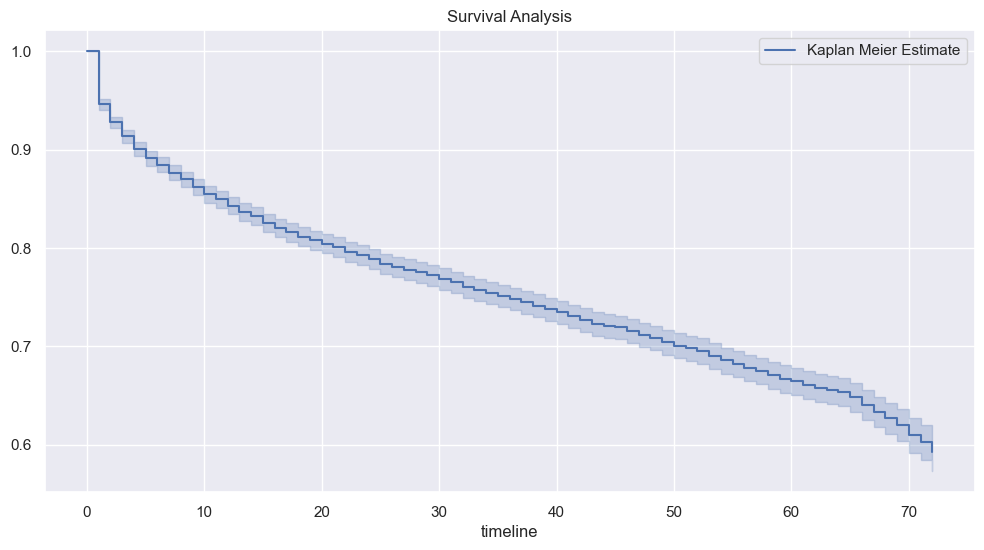

In [24]:
# Kaplan Meier Estimate
plt.figure(figsize=(12, 6))
km.fit(tenure, churn,label='Kaplan Meier Estimate')
km.plot_survival_function()
plt.title('Survival Analysis')
plt.show()

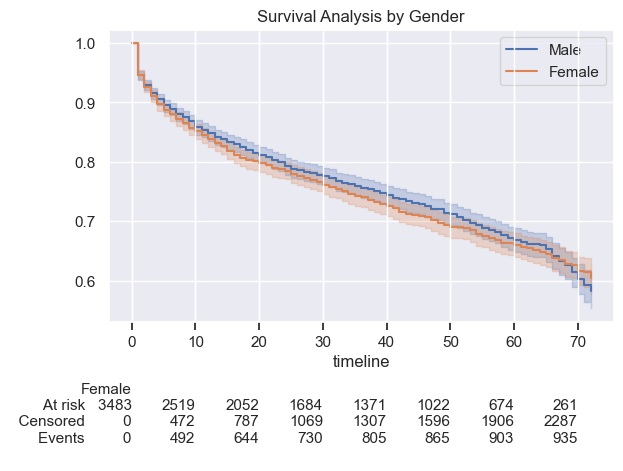

In [25]:
# Survival Analysis by Gender
ax = plt.subplot()
m = (dataset['Gender'] == 0)
km.fit(durations = tenure[m], event_observed = churn[m], label = "Male")
km.plot_survival_function(ax = ax)
km.fit(tenure[~m], event_observed = churn[~m], label = "Female")
km.plot_survival_function(ax = ax, at_risk_counts = True)
plt.title('Survival Analysis by Gender')
plt.show()

### Label Encoding 

In [26]:
# Using Pandas Library to Encode Payment Method Column
dataset = pd.get_dummies(dataset, columns=['Payment Method'], drop_first=True)

In [33]:
new_columns = list(dataset.columns)
new_columns[-1] = 'Payment Method(Mailed check)'
new_columns[-2] = 'Payment Method(Electronic check)'
new_columns[-3] = 'Payment Method(Credit card(automatic))'
dataset.columns = new_columns

### Correlation Heatmap

In [34]:
# Correlation Matrix
correlation_matrix = dataset.corr()

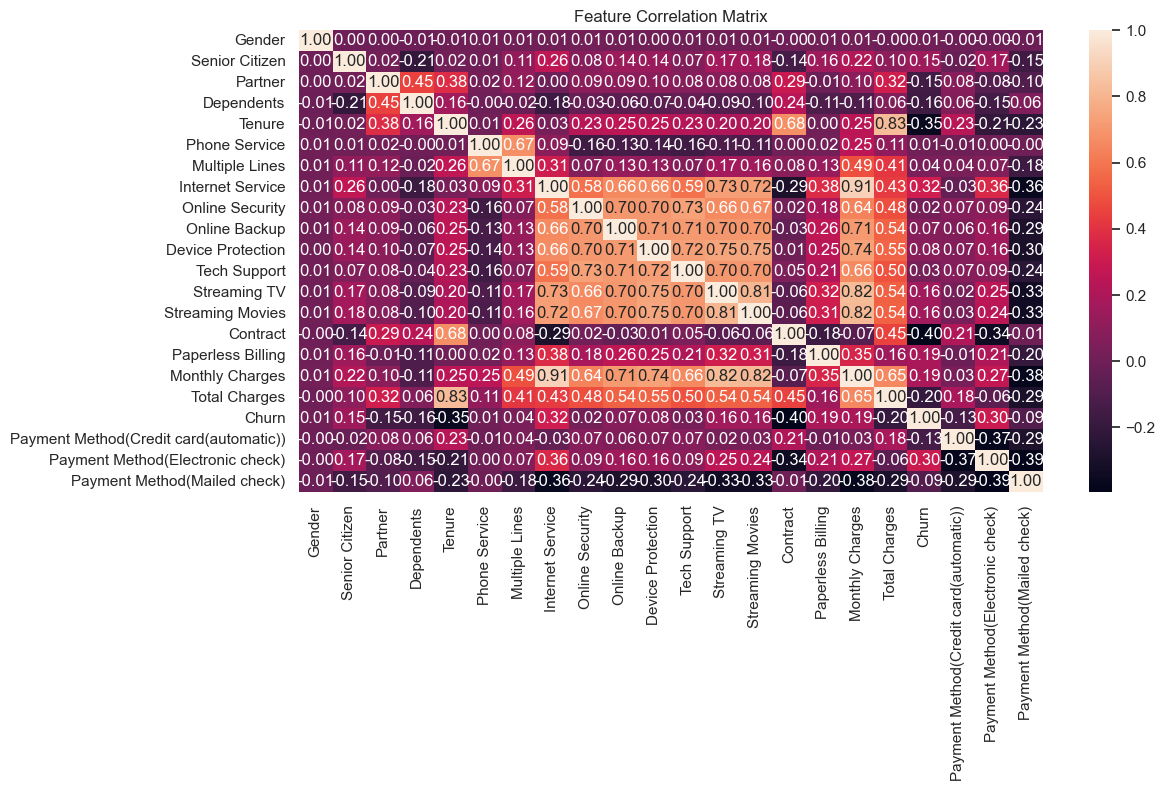

In [35]:
# Plotting Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

### Cox Proportional Hazard Model

In [36]:
cph = CoxPHFitter()
cph.fit(dataset, 'Tenure', 'Churn')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7032 total observations, 5163 right-censored observations>
             duration col = 'Tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7032
number of events observed = 1869
   partial log-likelihood = -12673.77
         time fit was run = 2024-04-26 14:22:32 UTC

---
                                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                      
Gender                                   0.03       1.04       0.05            -0.06             0.13                 0.94                 1.13
Senior Citizen                           0.03       1.03       0.06            -0.08             0.14                 0.92                 1.15
Partner                                 -0.18       0.83       0.06            -0.29            -0.08                 0.75                 0.93
Dependents                              -0.09       0.92       0.07            -0.22             0.05                 0.80                 1.05
Phone Service                            1.12       3.08       0.17             0.78             1.47                 2.19                 4.34
Multiple Lines                           0.20       1.22       0.06             0.08             0.32                 1.09                 1.38
Internet Service                         1.63       5.08       0.14             1.36             1.89                 3.89                 6.64
Online Security                         -0.07       0.93       0.06            -0.19             0.05                 0.83                 1.05
Online Backup                            0.08       1.08       0.05            -0.03             0.18                 0.97                 1.20
Device Protection                        0.23       1.25       0.06             0.12             0.34                 1.12                 1.40
Tech Support                             0.05       1.05       0.06            -0.07             0.18                 0.93                 1.19
Streaming TV                             0.54       1.71       0.08             0.39             0.69                 1.47                 1.98
Streaming Movies                         0.54       1.71       0.08             0.39             0.69                 1.48                 1.99
Contract                                -1.61       0.20       0.08            -1.77            -1.45                 0.17                 0.23
Paperless Billing                        0.15       1.16       0.06             0.04             0.26                 1.04                 1.30
Monthly Charges                         -0.01       0.99       0.01            -0.02            -0.00                 0.98                 1.00
Total Charges                           -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
Payment Method(Credit card(automatic))  -0.01       0.99       0.09            -0.19             0.16                 0.83                 1.18
Payment Method(Electronic check)         0.39       1.47       0.07             0.24             0.53                 1.28                 1.70
Payment Method(Mailed check)             0.51       1.66       0.09             0.34             0.68                 1.40                 1.97

                                         cmp to      z      p   -log2(p)
covariate                                                               
Gender                                     0.00   0.74   0.46       1.12
Senior Citizen                             0.00   0.57   0.57       0.82
Partner                                    0.00  -3.34 <0.005      10.23
Dependents                                 0.00  -1.25   0.21       2.25
Phone Service               

### Extracting Variables

In [37]:
# Independent Variables
X = dataset.drop(columns=['Churn'], axis=1)

# Dependent Variable
y = dataset.loc[:, 'Churn']

### Splitting Data

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

### Feature Scaling

In [39]:
# Standard Scaler will Scale Values between -3 to +3
sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

### GridSearchCV

In [50]:
# Models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'SVC': SVC(),
    'GaussianNB': GaussianNB(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier()
}

# Model Parameters
param_grids = {
    'RandomForestClassifier': {
        'n_estimators': [100, 300, 500],
        'max_depth': [10, 20, 30, None]
    },
    'SVC': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto']
    },
    'LogisticRegression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100]
    },
    'KNeighborsClassifier': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    'DecisionTreeClassifier': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'GaussianNB': {}
}

results = []

# Grid Search with Cross Validation
for key, value in models.items():
    grid_search = GridSearchCV(estimator=value, param_grid=param_grids[key],cv=10, n_jobs=-1, refit='accuracy', scoring='accuracy')
    grid_search.fit(X=X_train_scaled, y=y_train)
    print(f'\n{key}')
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_}\n{'-' * 85}")
    results.append({'model': key, 'params': grid_search.best_params_, 'accuracy': grid_search.best_score_})

grid_search_df = pd.DataFrame(results)


LogisticRegression
Best parameters: {'C': 1}
Best cross-validation accuracy: 0.8071098525312415
-------------------------------------------------------------------------------------

KNeighborsClassifier
Best parameters: {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'uniform'}
Best cross-validation accuracy: 0.7701386825787122
-------------------------------------------------------------------------------------

SVC
Best parameters: {'C': 1, 'gamma': 'scale'}
Best cross-validation accuracy: 0.800888731566405
-------------------------------------------------------------------------------------

GaussianNB
Best parameters: {}
Best cross-validation accuracy: 0.7343988419941467
-------------------------------------------------------------------------------------

DecisionTreeClassifier
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best cross-validation accuracy: 0.769959482437122
--------------------------------------------------------------------

### GridSearch Results

In [51]:
grid_search_df

,model,params,accuracy
0,LogisticRegression,{'C': 1},0.807110
1,KNeighborsClassifier,"{'algorithm': 'auto', 'n_neighbors': 7, 'weigh...",0.770139
2,SVC,"{'C': 1, 'gamma': 'scale'}",0.800889
3,GaussianNB,{},0.734399
4,DecisionTreeClassifier,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.769959
5,RandomForestClassifier,"{'max_depth': 10, 'n_estimators': 500}",0.800889


### Random Forest

In [52]:
# Fitting Model
model = RandomForestClassifier(max_depth=10, n_estimators=500)
model.fit(X_train_scaled, y_train)

# Making Prediction
y_pred = model.predict(X_test_scaled)

# Metrics
model_accuracy = accuracy_score(y_pred, y_test)
model_precision = precision_score(y_pred, y_test)
model_recall = recall_score(y_pred, y_test)
model_cm = confusion_matrix(y_pred, y_test)

### XGBoost

In [53]:
# Initialising Model
xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.01,
    max_depth=5,
    random_state=21
)

# Fitting Model
xgb.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=False)

# Making Prediction
y_pred = xgb.predict(X_test_scaled)

# Metrics
xgb_accuracy = accuracy_score(y_pred, y_test)
xgb_precision = precision_score(y_pred, y_test)
xgb_recall = recall_score(y_pred, y_test)
xgb_cm = confusion_matrix(y_pred, y_test)

### Artificial Neural Network

In [54]:
# Initialising Model
ann = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compiling Model
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fitting Model
ann.fit(X_train, y_train, epochs=50, batch_size=32)

# Making Prediction
y_pred = ann.predict(X_test) > 0.5

# Metrics
ann_accuracy = accuracy_score(y_pred, y_test)
ann_precision = precision_score(y_pred, y_test)
ann_recall = recall_score(y_pred, y_test)
ann_cm = confusion_matrix(y_pred, y_test)

Epoch 1/50
176/176 [==============================] - 1s 714us/step - loss: 0.8256 - accuracy: 0.6919
Epoch 2/50
176/176 [==============================] - 0s 642us/step - loss: 0.6059 - accuracy: 0.7554
Epoch 3/50
176/176 [==============================] - 0s 645us/step - loss: 0.6143 - accuracy: 0.7522
Epoch 4/50
176/176 [==============================] - 0s 641us/step - loss: 0.5088 - accuracy: 0.7746
Epoch 5/50
176/176 [==============================] - 0s 639us/step - loss: 0.5368 - accuracy: 0.7652
Epoch 6/50
176/176 [==============================] - 0s 640us/step - loss: 0.5708 - accuracy: 0.7618
Epoch 7/50
176/176 [==============================] - 0s 634us/step - loss: 0.5591 - accuracy: 0.7612
Epoch 8/50
176/176 [==============================] - 0s 695us/step - loss: 0.5174 - accuracy: 0.7794
Epoch 9/50
176/176 [==============================] - 0s 639us/step - loss: 0.5205 - accuracy: 0.7780
Epoch 10/50
176/176 [==============================] - 0s 637us/step - loss: 0.500

### Metrics Dataframe

In [55]:
metrics_df = pd.DataFrame([[model_accuracy, model_precision, model_recall, xgb_accuracy, xgb_precision, xgb_recall, ann_accuracy, ann_precision, ann_recall]], columns=['random_forest_accuracy', 'random_forest_precision', 'random_forest_recall', 'xgboost_accuracy', 'xgboost_precision', 'xgboost_recall', 'artificial_neural_network_accuracy', 'artificial_neural_network_precision', 'artificial_neural_network_recall'])

In [56]:
print(metrics_df)

   random_forest_accuracy  random_forest_precision  random_forest_recall  \
0                0.793888                    0.515              0.682119   

   xgboost_accuracy  xgboost_precision  xgboost_recall  \
0          0.771855               0.26        0.806202   

   artificial_neural_network_accuracy  artificial_neural_network_precision  \
0                            0.781805                                  0.4   

   artificial_neural_network_recall  
0                          0.704846  


### Confusion Matrix

In [57]:
print('Random Forest:', model_cm)
print('XGBoost:', xgb_cm)
print('Artificial Neural Network:', ann_cm)

Random Forest: [[911 194]
 [ 96 206]]
XGBoost: [[982 296]
 [ 25 104]]
Artificial Neural Network: [[940 240]
 [ 67 160]]


### LIME(Local Interpretable Model-agnostic Explanations)

In [58]:
# Initialising Explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['No', 'Yes'],
    mode='classification'
)

In [59]:
# Plotting Explainer
exp = explainer.explain_instance(
    data_row=X_test.iloc[1], 
    predict_fn=model.predict_proba
)
exp.show_in_notebook(show_table=True)